In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-surprise
# %pip install joblib

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
import os

In [2]:
# Function to read a single data file and return a DataFrame
def read_data_file(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        current_movie_id = None
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line.replace(':', ''))
            else:
                customer_id, rating, date = line.split(',')
                data_list.append([int(customer_id), current_movie_id, float(rating), date])
    return pd.DataFrame(data_list, columns=['Cust_Id', 'Movie_Id', 'Rating', 'Date'])

In [3]:
# Function to filter out inactive users based on the specified quantile threshold
def filter_active_users(ratings, quantile_threshold=0.7):
    ratings_count = ratings['Cust_Id'].value_counts()
    active_users = ratings_count[ratings_count >= ratings_count.quantile(quantile_threshold)].index
    return ratings[ratings['Cust_Id'].isin(active_users)]

In [4]:
# Function to prepare data for the Surprise library
def prepare_data_for_surprise(ratings):
    reader = Reader(rating_scale=(1, 5))
    return Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [5]:
# List of combined data files
data_files = [
    'combined_data_1.txt',
    'combined_data_2.txt',
    'combined_data_3.txt',
    'combined_data_4.txt'
]

In [6]:
# Load data from the first file for training
train_ratings_1 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[0]))

# Load data from the second file for training
train_ratings_2 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[1]))

# Concatenate training data
train_ratings = pd.concat([train_ratings_1, train_ratings_2])

print(train_ratings.head())


   Cust_Id  Movie_Id  Rating        Date
0  1488844         1     3.0  2005-09-06
1   822109         1     5.0  2005-05-13
2   885013         1     4.0  2005-10-19
3    30878         1     4.0  2005-12-26
4   823519         1     3.0  2004-05-03


In [7]:
del train_ratings_1
del train_ratings_2

In [8]:
# Filter inactive users from training data
train_ratings = filter_active_users(train_ratings)
print(train_ratings.shape)


(39042100, 4)


In [9]:
# Basic statistics for training data
print(train_ratings.describe())


            Cust_Id      Movie_Id        Rating
count  3.904210e+07  3.904210e+07  3.904210e+07
mean   1.321310e+06  4.662919e+03  3.565960e+00
std    7.645209e+05  2.596012e+03  1.073088e+00
min    6.000000e+00  1.000000e+00  1.000000e+00
25%    6.604350e+05  2.443000e+03  3.000000e+00
50%    1.316977e+06  4.736000e+03  4.000000e+00
75%    1.983132e+06  6.844000e+03  4.000000e+00
max    2.649429e+06  9.210000e+03  5.000000e+00


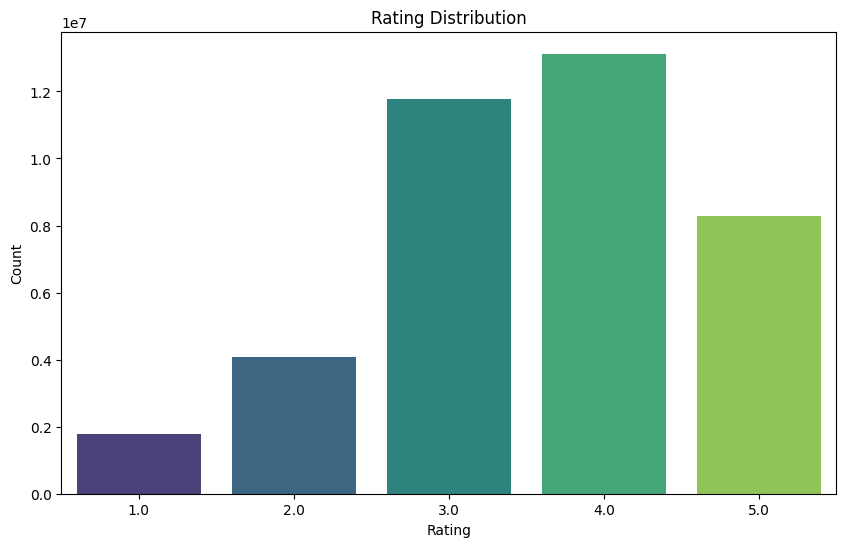

In [10]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_ratings, x='Rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


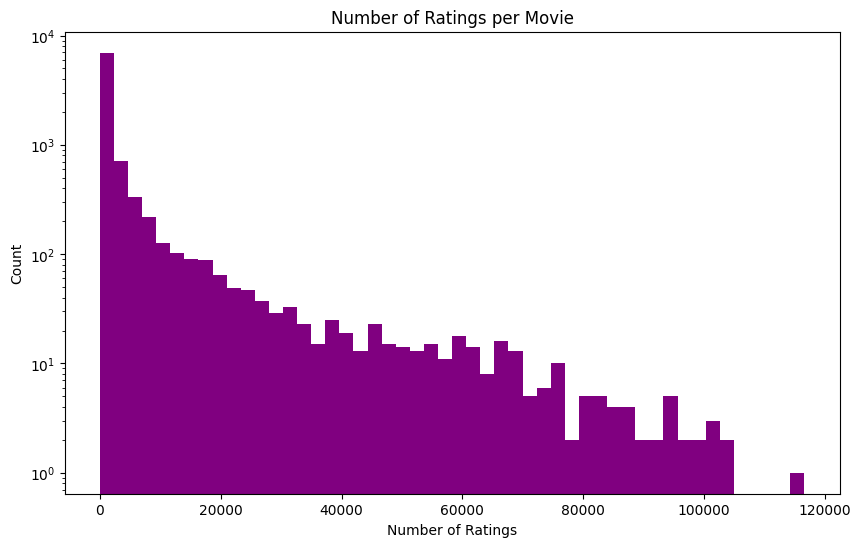

In [11]:
# Number of ratings per movie
ratings_per_movie = train_ratings.groupby('Movie_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='purple')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


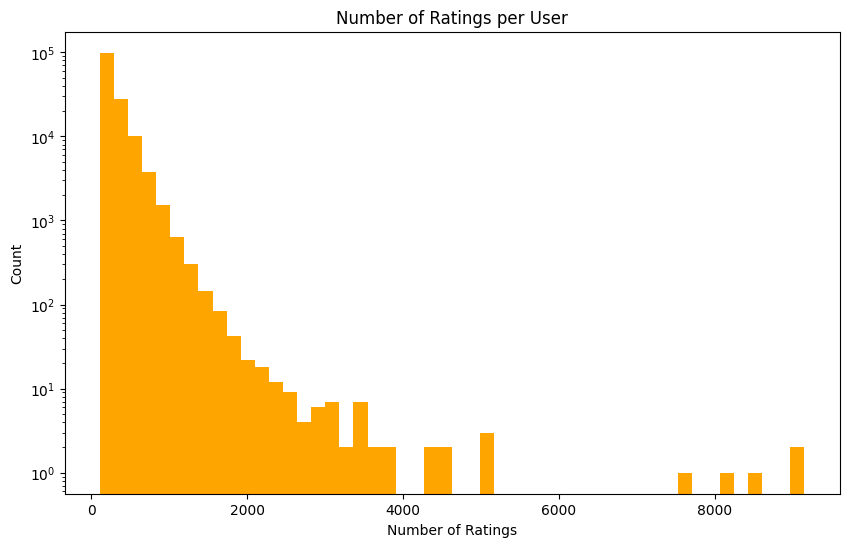

In [12]:
# Number of ratings per user
ratings_per_user = train_ratings.groupby('Cust_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='orange')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


In [13]:
# Prepare training data for the Surprise library
train_data = prepare_data_for_surprise(train_ratings)

In [ ]:
del train_ratings

In [ ]:
# Split the training data into train and validation sets
trainset, valset = train_test_split(train_data, test_size=0.25)


In [ ]:
del train_data

In [6]:
# Define the SVD model
algo = SVD(n_epochs=20)

In [16]:
# Train the SVD model
algo.fit(trainset)


In [ ]:
# Evaluate the model on the validation set
val_predictions = algo.test(valset)
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)
print(f'Validation RMSE: {val_rmse}, Validation MAE: {val_mae}')


In [18]:
# Clear unnecessary data structures to free up memory
del trainset
del valset
del val_predictions

import gc
gc.collect()

0

In [19]:
# Save the trained model to a file
model_filename = 'svd_model.joblib'
joblib.dump(algo, model_filename)
print(f"Model saved to {model_filename}")

Model saved to svd_model.joblib


In [8]:
# Load the saved model
model_filename = 'svd_model.joblib'
algo = joblib.load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [9]:
# Load additional data files
train_ratings_3 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[2]))
train_ratings_4 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[3]))

In [10]:
# Concatenate the additional data with the existing training data
additional_ratings = pd.concat([train_ratings_3, train_ratings_4])

In [11]:
del train_ratings_3
del train_ratings_4

In [12]:
# Filter inactive users from additional training data
additional_ratings = filter_active_users(additional_ratings)
print(additional_ratings.shape)

(37379218, 4)


In [13]:
# Basic statistics for additional data
print(additional_ratings.describe())

            Cust_Id      Movie_Id        Rating
count  3.737922e+07  3.737922e+07  3.737922e+07
mean   1.321372e+06  1.361210e+04  3.587239e+00
std    7.645346e+05  2.420859e+03  1.071907e+00
min    6.000000e+00  9.211000e+03  1.000000e+00
25%    6.608210e+05  1.152100e+04  3.000000e+00
50%    1.317009e+06  1.369100e+04  4.000000e+00
75%    1.983213e+06  1.567100e+04  4.000000e+00
max    2.649429e+06  1.777000e+04  5.000000e+00


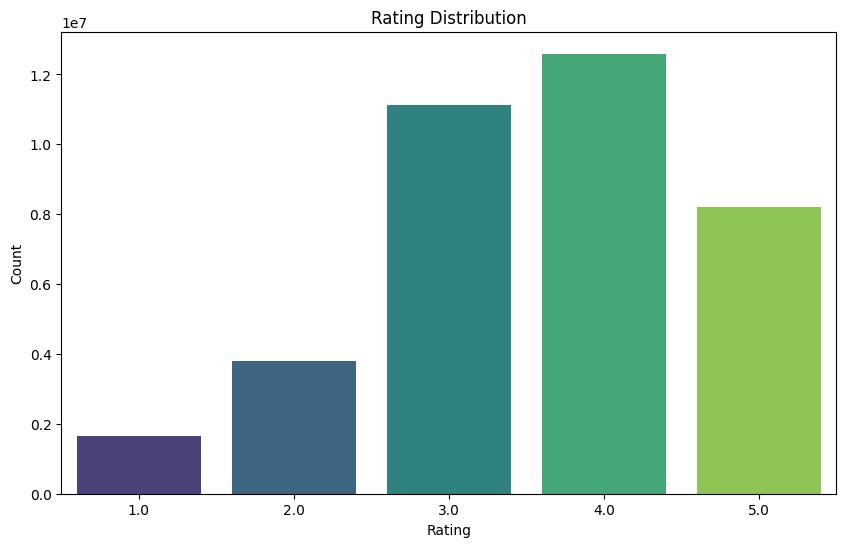

In [14]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=additional_ratings, x='Rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

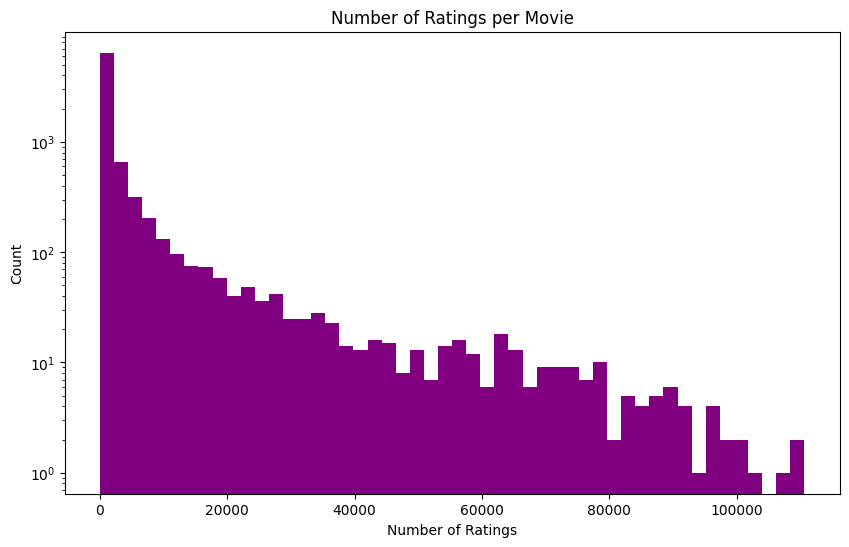

In [15]:
# Number of ratings per movie
ratings_per_movie = additional_ratings.groupby('Movie_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='purple')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

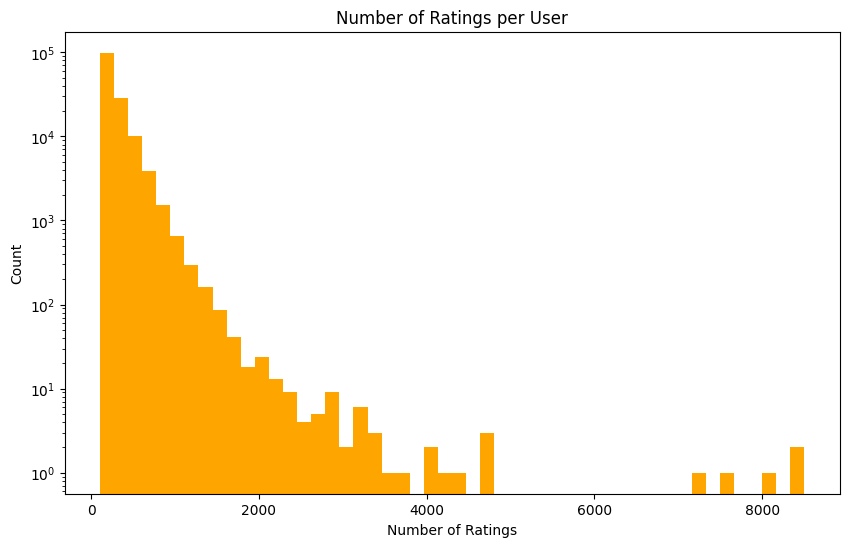

In [16]:
# Number of ratings per user
ratings_per_user = additional_ratings.groupby('Cust_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='orange')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [17]:
# Prepare additional data for the Surprise library
additional_data = prepare_data_for_surprise(additional_ratings)

In [18]:
del additional_ratings

In [19]:
# Split the additional data into train and validation sets
additional_trainset, additional_valset = train_test_split(additional_data, test_size=0.25)

In [20]:
del additional_data

In [ ]:
# Train the model incrementally with additional data
algo.fit(additional_trainset)

In [22]:
# Evaluate the model on the additional validation set
additional_val_predictions = algo.test(additional_valset)
additional_val_rmse = accuracy.rmse(additional_val_predictions)
additional_val_mae = accuracy.mae(additional_val_predictions)
print(f'Additional Validation RMSE: {additional_val_rmse}, Additional Validation MAE: {additional_val_mae}')

RMSE: 0.8231
MAE:  0.6377
Additional Validation RMSE: 0.8230955789179476, Additional Validation MAE: 0.6377092993147249


In [23]:
# Clear unnecessary data structures to free up memory
del additional_trainset
del additional_valset

import gc
gc.collect()

0

In [24]:
# Save the updated model
updated_model_filename = 'svd_model_updated.joblib'
joblib.dump(algo, updated_model_filename)
print(f"Updated model saved to {updated_model_filename}")

Updated model saved to svd_model_updated.joblib


In [ ]:
# Load the saved model
updated_model_filename = 'svd_model_updated.joblib'
algo = joblib.load(model_filename)
print("Model loaded successfully")

In [25]:
# Example prediction for a specific user and movie
user_id = '712664'  # replace with a valid user ID from your dataset
movie_id = '3'      # replace with a valid movie ID from your dataset
prediction = algo.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {prediction.est:.2f}")


Predicted rating for user 712664 and movie 3: 3.59


In [34]:
# Function to get top-N recommendations for a user
def get_top_n_recommendations(algo, user_id, ratings, n=10):
    # Get all movie IDs
    all_movie_ids = ratings['Movie_Id'].unique()
    
    # Get movie IDs the user has already rated
    rated_movie_ids = ratings[ratings['Cust_Id'] == int(user_id)]['Movie_Id']
    
    # Create a list of (movie_id, predicted_rating) for movies not yet rated by the user
    predictions = [algo.predict(user_id, str(movie_id)) for movie_id in all_movie_ids if movie_id not in rated_movie_ids]
    
    # Sort the predictions by estimated rating in descending order
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Extract the movie IDs and estimated scores from the top-N predictions
    top_n_movie_ids = [int(pred.iid) for pred in top_n_predictions]
    top_n_scores = [pred.est for pred in top_n_predictions]
    
    return top_n_movie_ids, top_n_scores

In [31]:
# Get top 10 recommendations for a specific user
user_id = '712664'  # Replace with the user ID you want to get recommendations for
# Reload train_ratings to get top recommendations
train_ratings_1 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[0]))
train_ratings_2 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[1]))
print("Data loaded successfully")

train_ratings = pd.concat([train_ratings_1, train_ratings_2])
train_ratings = filter_active_users(train_ratings)
top_n_recommendations, top_n_scores = get_top_n_recommendations(algo, user_id, train_ratings, n=10)
print(f"Top 10 movie recommendations for user {user_id}: {top_n_recommendations}")

Data loaded successfully
Top 10 movie recommendations for user 712664: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [39]:
# Load movie titles with custom parser to handle inconsistent number of columns
def read_movie_titles(file_path):
    movie_titles = []
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            parts = line.strip().split(',', 2)
            if len(parts) == 3:
                movie_id, year, name = parts
                try:
                    movie_id = int(movie_id)
                except ValueError:
                    continue
                if year == 'NULL':
                    year = None
                else:
                    try:
                        year = int(year)
                    except ValueError:
                        continue
                movie_titles.append([movie_id, year, name])
    return pd.DataFrame(movie_titles, columns=['Movie_Id', 'Year', 'Name'])

movie_titles = read_movie_titles('/kaggle/input/netflix-prize-data/movie_titles.csv')

In [40]:
# Display recommendations
recommended_movies = pd.DataFrame({
    'Movie_Id': top_n_recommendations,
    'Estimated Score': top_n_scores
})

recommended_movies = recommended_movies.merge(movie_titles, on='Movie_Id')

In [41]:
# Fetch user ratings
user_ratings = train_ratings[train_ratings['Cust_Id'] == int(user_id)]
user_ratings = user_ratings.merge(movie_titles, on='Movie_Id')
user_ratings = user_ratings[user_ratings['Rating'] == 5]

# Display the results
print("Movies rated as 5 stars by user with userId = 712664")
print(user_ratings[['Movie_Id', 'Year', 'Name', 'Rating']])

print("\nPredict movies that would receive high ratings for this user")
print(recommended_movies[['Movie_Id', 'Year', 'Name', 'Estimated Score']])

Movies rated as 5 stars by user with userId = 712664
     Movie_Id    Year                        Name  Rating
0           3  1997.0                   Character     5.0
5          79  1956.0                 The Killing     5.0
11        175  1992.0              Reservoir Dogs     5.0
14        199  1978.0             The Deer Hunter     5.0
17        241  1959.0          North by Northwest     5.0
..        ...     ...                         ...     ...
859      8976  1950.0                      Harvey     5.0
862      8998  1962.0  The Twilight Zone: Vol. 40     5.0
864      9042  1957.0              Paths of Glory     5.0
867      9049  1997.0               Boogie Nights     5.0
868      9051  1980.0                  Caddyshack     5.0

[236 rows x 4 columns]

Predict movies that would receive high ratings for this user
   Movie_Id    Year                          Name  Estimated Score
0         1  2003.0               Dinosaur Planet         3.587249
1         2  2004.0    Isle of 

In [42]:
import zipfile

# Path to the model file
model_filename = 'svd_model_updated.joblib'

# Name of the zip file
zip_filename = 'svd_model.zip'

# Create a zip file and add the model file to it
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_filename)

print(f"Model has been zipped and saved as {zip_filename}")


Model has been zipped and saved as svd_model.zip
